In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

from helper import *
import json
import pickle
import os
from datetime import datetime

# Colab

In [ ]:
from google.colab import drive
drive.mount('./drive')

In [ ]:
!cp -r ./drive/MyDrive/horse_racing .

In [ ]:
from horse_racing.helper import *

In [ ]:
!unzip ./horse_racing/selected_data.zip -d .

# Metrics

In [2]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
scores = {}

# Data

In [3]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [4]:
def data_gen(X, y, test_size = 0.05):
  test_size = int(test_size*y.shape[0])
  idx = list(range(X.shape[0]))
  yield idx[:-test_size], idx[-test_size:]
  yield idx[:-2*test_size] + idx[-test_size:], idx[-2*test_size:-test_size]


In [5]:
with open('../src/app_data/selected_features.json', 'r') as f:
    selected_features = json.load(f)['selected_features']

In [6]:
df = pd.read_csv('../data/selected_data.csv')


In [7]:
nrace_test = int(df['raceid'].apply(lambda x: True if x.split('-')[0] == '2018' else False).sum())
print('Number of races in 2018:', nrace_test)


Number of races in 2018: 25402


In [8]:
kettoNum = df['KettoNum']
X = df[selected_features]
y = df['Top 3']
top3 = df['Top 3']
raceid = df['raceid']
X_train, X_test, y_train, y_test, top3_train, top3_test, raceid_train, raceid_test = split_data(X, y, raceid, top3,
                                                                                                drop_columns=None,
                                                                                                select_cols=None,
                                                                                                test_size=nrace_test)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
X_train.head()

(500261, 30) (500261,)
(25402, 30) (25402,)


,Barei,BaTaijyu,SexCD_1,SexCD_2,SexCD_3,HinsyuCD_1,HinsyuCD_2,TozaiCD_3,TrackCD_Dirt,TrackCD_Turf,...,jockey_beta=0.07_top3,jockey_beta=0.1_top3,owner_top3,owner_top5,coach_n_races,coach_top1,coach_top3,horse_top3_rate,owner_top3_rate,jockey_top5_rate
0,3,428.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.207452,0.207452,0.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0
1,3,450.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.207452,0.207452,0.0,173.0,1.0,0.0,0.0,0.0,0.0,0.0
2,3,458.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.207452,0.207452,0.0,2651.0,1.0,0.0,0.0,0.0,0.0,0.0
3,3,402.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.207452,0.207452,0.0,518.0,1.0,0.0,0.0,0.0,0.0,0.0
4,3,482.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.207452,0.207452,0.0,202.0,1.0,0.0,0.0,0.0,0.0,0.0


# Model

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [10]:
def finetuning(X, y, estimator = None, test_size=0.05,**kwargs):

  params_list = []
  kwargs_keys = list(kwargs.keys())
  for arg in kwargs_keys:
    if 'param' in arg:
      params_list.append(kwargs.pop(arg))
  current_params = estimator.get_params()
  for params in params_list:
    start_time = datetime.now()
    estimator.set_params(**current_params)
    model = GridSearchCV(estimator, param_grid=params, cv = data_gen(X, y, test_size=test_size))
    model.fit(X, y)
    end_time = datetime.now()
    print(f'Training with {params} took {(end_time-start_time).total_seconds()} seconds')
    current_params = model.best_estimator_.get_params()
  return model.best_estimator_
  

## Logistic Regression

In [10]:
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

In [ ]:
estimator = LogisticRegression(max_iter=300, solver='liblinear')
params1 = {
    'penalty': ['l1','l2'],
    'class_weight': [None,'balanced']
}
params2 = {'C':[0.1,0.5,1.0]}
model_log = finetuning(X_train_sc, y_train.values, estimator=estimator, params1=params1, params2=params2)


In [ ]:
top3_pred = predict_top3_prob(model_log, X_train_sc, raceid_train)
print('Total accuracy:', accuracy_score(top3_train, top3_pred['Top 3']))
print('Top 3 prediction accuracy:', top3_accuracy_score(top3_train.values, top3_pred['Top 3'].values))
ax = sns.heatmap(confusion_matrix(top3_train, top3_pred['Top 3']), annot=True, fmt='.0f', cmap='Blues')

In [ ]:
top3_pred = predict_top3_prob(model_log, X_test_sc, raceid_test)
scores['log'] = top3_accuracy_score(top3_test.values, top3_pred['Top 3'].values)
print('Total accuracy:', accuracy_score(top3_test, top3_pred['Top 3']))
print('Top 3 prediction accuracy:', scores['log'])
ax = sns.heatmap(confusion_matrix(top3_test, top3_pred['Top 3']), annot=True, fmt='.0f', cmap='Blues')

In [ ]:
with open('model_log.pickle', 'wb') as f:
  f.write(pickle.dumps(model_log))

## Gradient Boost

In [ ]:
estimator = GradientBoostingClassifier(max_depth=8)
params1 = {
    'n_estimators': [50, 100, 150],
}
params2 = {
    'max_depth': [5,8,11],
    'learning_rate':[0.1,0.3]
}

model_gb = finetuning(X_train.values, y_train.values, estimator=estimator, params1=params1, params2=params2)


In [ ]:
# model = model_gb.best_estimator
top3_pred = predict_top3_prob(model_gb, X_test, raceid_test)
print('Total accuracy:', accuracy_score(top3_test, top3_pred['Top 3']))
scores['gb'] = top3_accuracy_score(top3_test.values, top3_pred['Top 3'].values)
print('Top 3 prediction accuracy:', scores['gb'])
ax = sns.heatmap(confusion_matrix(top3_test, top3_pred['Top 3']), annot=True, fmt='.0f', cmap='Blues')

## XGBoost

In [ ]:
estimator = XGBClassifier()
params1 = {
    "subsample": [0.6,0.8,1.],
    "n_estimators": [50, 100, 150]
}
params2 = {
    "learning_rate":[0.1, 0.3],
    "max_depth": [5, 8, 11]
}
params3 = {
    "reg_lambda": [1, 2, 3],
    "gamma": [0.5, 1.5, 2.5]
}
model_xgb = finetuning(X_train.values, y_train.values, estimator=estimator, params1=params1, params2=params2, params3=params3)

In [ ]:
top3_pred = predict_top3_prob(model_xgb, X_test.values, raceid_test)
scores['xgb'] = top3_accuracy_score(top3_test.values, top3_pred['Top 3'].values)
print('Total accuracy:', accuracy_score(top3_test, top3_pred['Top 3']))
print('Top 3 prediction accuracy:', scores['xgb'])
ax = sns.heatmap(confusion_matrix(top3_test, top3_pred['Top 3']), annot=True, fmt='.0f', cmap='Blues')

In [ ]:
model_xgb.save_model(r'..\src\modelcheckpoint\model_xgb.json')
with open('model_xgb_params.json', 'w') as f:
  f.write(json.dumps(model_xgb.get_params()))

## DNN model

In [54]:
X_train, X_val, y_train, y_val, top3_train, top3_val, raceid_train, raceid_val = split_data(X_train, y_train, raceid_train, top3_train,
                                                                                                drop_columns=None,
                                                                                                select_cols=None,
                                                                                                test_size=0.05)

In [55]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)
X_val_sc = scaler.transform(X_val)
X_test_sc = scaler.transform(X_test)

### Model

In [56]:
model_nn = tf.keras.Sequential([
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu', kernel_regularizer =tf.keras.regularizers.L2()),
    tf.keras.layers.BatchNormalization(momentum=0.99),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu', kernel_regularizer =tf.keras.regularizers.L2()),
    tf.keras.layers.BatchNormalization(momentum=0.99),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(30, activation='relu', kernel_regularizer =tf.keras.regularizers.L2()),
    tf.keras.layers.BatchNormalization(momentum=0.99),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(30, activation='relu', kernel_regularizer =tf.keras.regularizers.L2()),
    tf.keras.layers.BatchNormalization(momentum=0.99),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu', kernel_regularizer =tf.keras.regularizers.L2()),
    tf.keras.layers.BatchNormalization(momentum=0.99),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [57]:
model_nn.compile(
                loss = tf.keras.losses.BinaryFocalCrossentropy(),
                # loss = 'binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=['acc'])

In [12]:
ckpt_folder = os.path.join('..','src','modelcheckpoint')
callbacks = callbacks=[tf.keras.callbacks.ReduceLROnPlateau(fractions=0.1,monitor='val_loss', patience=3),
                       tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=12, min_delta=0.0001),
                       tf.keras.callbacks.ModelCheckpoint(os.path.join(ckpt_folder,'model_nn.hdf5'), save_best_only=True)]

In [59]:
history = model_nn.fit(X_train_sc, y_train,
                       epochs = 200,
                       validation_data=(X_val_sc, y_val),
                       batch_size=1024,
                       callbacks=callbacks)

Epoch 1/200
465/465 [==============================] - 4s 6ms/step - loss: 0.7686 - acc: 0.7653 - val_loss: 0.3182 - val_acc: 0.7855 - lr: 0.0010
Epoch 2/200
465/465 [==============================] - 3s 6ms/step - loss: 0.1745 - acc: 0.7953 - val_loss: 0.1635 - val_acc: 0.7855 - lr: 0.0010
Epoch 3/200
465/465 [==============================] - 3s 6ms/step - loss: 0.1249 - acc: 0.7961 - val_loss: 0.1238 - val_acc: 0.7854 - lr: 0.0010
Epoch 4/200
465/465 [==============================] - 3s 6ms/step - loss: 0.1188 - acc: 0.7966 - val_loss: 0.1336 - val_acc: 0.7437 - lr: 0.0010
Epoch 5/200
465/465 [==============================] - 3s 5ms/step - loss: 0.1179 - acc: 0.7968 - val_loss: 0.1239 - val_acc: 0.7887 - lr: 0.0010
Epoch 6/200
465/465 [==============================] - 3s 6ms/step - loss: 0.1176 - acc: 0.7968 - val_loss: 0.1206 - val_acc: 0.7914 - lr: 0.0010
Epoch 7/200
465/465 [==============================] - 3s 6ms/step - loss: 0.1174 - acc: 0.7971 - val_loss: 0.1262 - val_acc

### Evaluate

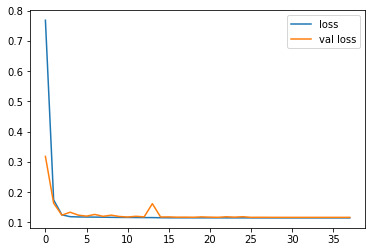

In [60]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()

In [61]:
model_nn = tf.keras.models.load_model(os.path.join(ckpt_folder, 'model_nn.hdf5'))

In [ ]:
top3_pred = predict_top3_prob(model_nn, X_train_sc, raceid_train)
print('Total accuracy:', accuracy_score(top3_train, top3_pred['Top 3']))
print('Top 3 prediction accuracy:', scores['train'][-1])
ax = sns.heatmap(confusion_matrix(top3_train, top3_pred['Top 3']), annot=True, fmt='.0f', cmap='Blues')

In [ ]:
top3_pred = predict_top3_prob(model_nn, X_val_sc, raceid_val)
print('Total accuracy:', accuracy_score(top3_val, top3_pred['Top 3']))
print('Top 3 prediction accuracy:', top3_accuracy_score(top3_val.values, top3_pred['Top 3'].values))
ax = sns.heatmap(confusion_matrix(top3_val, top3_pred['Top 3']), annot=True, fmt='.0f', cmap='Blues')

Total accuracy: 0.7865522399811038
Top 3 prediction accuracy: 0.4839931805266149


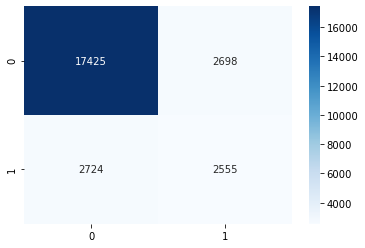

In [23]:
top3_pred = predict_top3_prob(model_nn, X_test_sc, raceid_test)
print('Total accuracy:', accuracy_score(top3_test, top3_pred['Top 3']))
scores['dnn'] = top3_accuracy_score(top3_test.values, top3_pred['Top 3'].values)
print('Top 3 prediction accuracy:', scores['dnn'])
ax = sns.heatmap(confusion_matrix(top3_test, top3_pred['Top 3']), annot=True, fmt='.0f', cmap='Blues')

## Ensemble model

In [13]:
model_xgb = XGBClassifier()
model_xgb.load_model(os.path.join(ckpt_folder, 'model_xgb.json'))

In [14]:
model_nn = tf.keras.models.load_model(os.path.join(ckpt_folder, 'model_nn.hdf5'))

Total accuracy: 0.7897803322573026
Top 3 prediction accuracy: 0.4917598029929911


Text(33.0, 0.5, 'True')

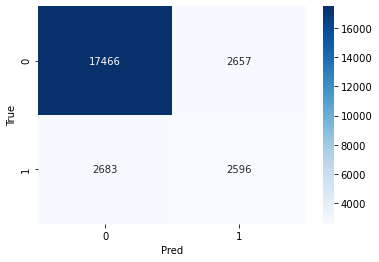

In [16]:
top3_pred = predict_top3_prob_multimodels([model_xgb,model_nn], [X_test,X_test_sc], raceid_test)
print('Total accuracy:', accuracy_score(top3_test, top3_pred['Top 3']))
scores['ensemble'] = top3_accuracy_score(top3_test.values, top3_pred['Top 3'].values)
print('Top 3 prediction accuracy:', scores['ensemble'])
sns.heatmap(confusion_matrix(top3_test, top3_pred['Top 3']), annot=True, fmt='.0f', cmap='Blues')
plt.xlabel('Pred')
plt.ylabel('True')

In [ ]:
with open(os.path.join('..','reports','score', 'model_scores.json'), 'w') as f:
    f.write(json.dumps(scores))

# Predict and save predictions

In [17]:
data_path = os.path.join('..','src','app_data')
# data_path = './'

Total accuracy: 0.7814626481224662
Top 3 prediction accuracy: 0.4723888124713434


Text(33.0, 0.5, 'True')

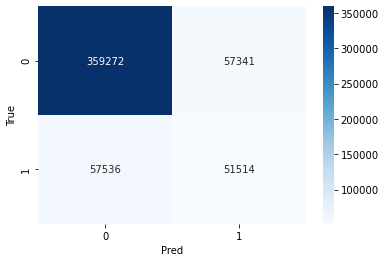

In [18]:
top3_pred = predict_top3_prob_multimodels([model_xgb,model_nn], [X,scaler.transform(X)], raceid)
print('Total accuracy:', accuracy_score(top3, top3_pred['Top 3']))
print('Top 3 prediction accuracy:', top3_accuracy_score(top3.values, top3_pred['Top 3'].values))
sns.heatmap(confusion_matrix(top3, top3_pred['Top 3']), annot=True, fmt='.0f', cmap='Blues')
plt.xlabel('Pred')
plt.ylabel('True')

In [20]:
top3_pred['KettoNum'] = kettoNum
top3_pred['Truth'] = top3
top3_pred = top3_pred[['raceid', 'KettoNum', 'Top 3 prob', 'Top 3', 'Truth']]
top3_pred.rename({"Top 3": 'Top 3 pred'}, axis=1, inplace= True)
top3_pred.head()

,raceid,KettoNum,Top 3 prob,Top 3 pred,Truth
0,2008-01-05 01:06,2005107051,0.174859,False,False
1,2008-01-05 01:06,2005102028,0.199353,False,True
2,2008-01-05 01:06,2005104156,0.273760,True,True
3,2008-01-05 01:06,2005105319,0.178951,False,False
4,2008-01-05 01:06,2005101044,0.215933,True,True


In [21]:
top3_pred.to_csv(os.path.join(data_path,'historical_race_results.csv'), index=False)

In [22]:
with open(os.path.join(data_path + 'scaler.pickle'), 'wb') as f:
    f.write(pickle.dumps(scaler))